# Credit Risk Project — PD Model → Bank Decisions

**Goal:** build a Probability of Default (PD) model and translate it into bank decisions (Approve / Review / Reject) using a simple risk policy.

This notebook is structured for **portfolio / GitHub**:
- Clean EDA (leakage-safe) + one-page dashboard
- Statistical tests (Spearman, Kruskal–Wallis, ANOVA)
- Modeling (baseline + stronger model), calibration, business thresholding
- Final decision table (PD → LGD/EAD → Expected Loss → APR/Limit → Decision)

> **Note on leakage:** post-outcome repayment fields (e.g., `total_pymnt`, `recoveries`) are excluded from explanatory EDA and model inputs.


In [23]:
import os
import re
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass


from scipy import stats
from scipy.stats import spearmanr, kruskal

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import OrdinalEncoder

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)


## 1) Load data

You can load your CSV either from a local path or via `kagglehub` (optional).

In [24]:
dataset_path = kagglehub.dataset_download("jorgesalasf/credit-risk-dataset")
csv_path = os.path.join(dataset_path, "loan.csv")
df_raw = pd.read_csv(csv_path, low_memory=False)

# If you already have df_raw in memory, comment out the load lines above.
assert "df_raw" in globals(), "df_raw not found. Load the dataset first (OPTION A or B)."
print("Raw shape:", df_raw.shape)
df_raw.head(3)


Raw shape: (887379, 74)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.0,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2) Utility Functions — Handling Sparse vs Dense Data in ML Pipelines

During model benchmarking, a pipeline error occurred due to a mismatch between feature encoding and model input requirements.

By default, `OneHotEncoder` outputs **sparse matrices**, which are compatible with linear models such as Logistic Regression.  
However, tree-based models like `HistGradientBoostingClassifier` **require dense numerical inputs**.

To address this properly and avoid ad-hoc conversions, the preprocessing strategy was adapted by model type:

- **Logistic Regression** → `OneHotEncoder` (sparse input supported)
- **HistGradientBoostingClassifier** → `OrdinalEncoder` (dense, memory-efficient)

This design choice ensures:
- Compatibility with each model’s internal implementation
- Cleaner pipelines without manual `.toarray()` conversions
- Better scalability and maintainability of the notebook

The resulting pipelines are robust, reusable, and aligned with industry best practices.



In [25]:
def make_preprocess_for_model(X, numeric_cols, categorical_cols, model_name: str):
    """Model-specific preprocessing.
    - log_reg: OneHotEncoder (sparse OK)
    - hgb: OrdinalEncoder (dense + efficient)
    """
    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    if model_name == "hgb":
        cat_pipe = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ])
        preprocess = ColumnTransformer(
            transformers=[
                ("num", num_pipe, numeric_cols),
                ("cat", cat_pipe, categorical_cols)
            ],
            remainder="drop",
            sparse_threshold=0.0
        )
        return preprocess

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])
    preprocess = ColumnTransformer(
        transformers=[
            ("num", num_pipe, numeric_cols),
            ("cat", cat_pipe, categorical_cols)
        ],
        remainder="drop"
    )
    return preprocess


In [1]:
# This block defines the full “data + modeling toolkit”: it labels good/bad loans, removes leakage features, and cleans key fields for training.
# It also builds the preprocessing pipeline (impute/scale/one-hot), evaluates models with AUC/AP, and selects a cost-optimized decision threshold.
# Finally, it creates a one-page EDA dashboard to visualize default patterns across key variables and segments (grade, DTI, utilization, purpose, etc.).
# The stats-testing function adds quick evidence (Spearman/Kruskal/ANOVA) to verify whether observed relationships are meaningful, not random.
DEFAULT_BAD = {
    "Charged Off","Default","Late (31-120 days)","Late (16-30 days)",
    "Does not meet the credit policy. Status:Charged Off",
}
GOOD_STATUSES = {"Fully Paid","Does not meet the credit policy. Status:Fully Paid"}

LEAKAGE_COLS = [
    "total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int",
    "total_rec_late_fee","recoveries","collection_recovery_fee",
    "last_pymnt_amnt","out_prncp","out_prncp_inv","next_pymnt_d",
    "last_pymnt_d","last_credit_pull_d"
]

def parse_term(x):
    if pd.isna(x): 
        return np.nan
    s = str(x)
    digits = "".join(c for c in s if c.isdigit())
    return float(digits) if digits else np.nan

def coerce_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def drop_high_missing(df, keep_cols=("loan_status",), thresh=0.90):
    miss = df.isna().mean()
    drop = [c for c in df.columns if (miss.get(c, 0) >= thresh and c not in keep_cols)]
    return df.drop(columns=drop, errors="ignore")

def build_target_default(df, status_col="loan_status"):
    if status_col not in df.columns:
        raise KeyError(f"'{status_col}' not found.")
    return df[status_col].astype(str).isin(DEFAULT_BAD).astype(int)

def filter_final_outcomes(df, status_col="loan_status"):
    if status_col not in df.columns:
        raise KeyError(f"'{status_col}' not found.")
    keep = df[df[status_col].astype(str).isin(GOOD_STATUSES.union(DEFAULT_BAD))].copy()
    keep["target_default"] = keep[status_col].astype(str).isin(DEFAULT_BAD).astype(int)
    return keep

def make_preprocess(X, numeric_cols, categorical_cols, scale_numeric=True):
    num_steps = [("imputer", SimpleImputer(strategy="median"))]
    if scale_numeric:
        num_steps.append(("scaler", StandardScaler()))
    numeric_pipe = Pipeline(steps=num_steps)

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    return ColumnTransformer(
        transformers=[
            ("num", numeric_pipe, numeric_cols),
            ("cat", cat_pipe, categorical_cols)
        ],
        remainder="drop"
    )

def eval_binary_model(model, X_train, y_train, X_valid, y_valid, X_test, y_test):
    model.fit(X_train, y_train)
    p_valid = model.predict_proba(X_valid)[:, 1]
    p_test  = model.predict_proba(X_test)[:, 1]
    return {
        "valid_auc": roc_auc_score(y_valid, p_valid),
        "test_auc":  roc_auc_score(y_test,  p_test),
        "valid_ap":  average_precision_score(y_valid, p_valid),
        "test_ap":   average_precision_score(y_test,  p_test),
        "model": model,
        "p_valid": p_valid,
        "p_test": p_test
    }

def select_threshold_by_cost(y_true, p, loss_fn=5.0, loss_fp=1.0, grid=None):
    if grid is None:
        grid = np.linspace(0.01, 0.50, 100)
    best = None
    for t in grid:
        y_pred = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        cost = fn*loss_fn + fp*loss_fp
        if best is None or cost < best["cost"]:
            best = {"threshold": float(t), "cost": float(cost), "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)}
    return best

def one_page_eda_dashboard(df_eda, target="target_default", out_dir="assets", fname="eda_dashboard.png"):
    os.makedirs(out_dir, exist_ok=True)
    fig, axes = plt.subplots(2, 4, figsize=(22, 10))
    axes = axes.ravel()

    def default_rate_by_quantile(df, x, q=10, clip=(0.01, 0.99)):
        tmp = df[[x, target]].dropna().copy()
        if tmp.empty:
            return None
        lo, hi = tmp[x].quantile(clip[0]), tmp[x].quantile(clip[1])
        tmp[x] = tmp[x].clip(lo, hi)
        tmp["bin"] = pd.qcut(tmp[x], q=q, duplicates="drop")
        return tmp.groupby("bin")[target].mean()

    # 1) Default by grade
    if {"grade", target}.issubset(df_eda.columns):
        tmp = df_eda.dropna(subset=["grade", target]).copy()
        order = sorted(tmp["grade"].unique())
        rates = tmp.groupby("grade")[target].mean().reindex(order)
        axes[0].bar(rates.index.astype(str), rates.values)
        axes[0].set_title("Default Rate by Grade")
        axes[0].set_xlabel("Grade")
        axes[0].set_ylabel("Default Rate")
    else:
        axes[0].axis("off")

    # 2) int_rate by grade
    if {"grade", "int_rate"}.issubset(df_eda.columns):
        tmp = df_eda.dropna(subset=["grade", "int_rate"]).copy()
        order = sorted(tmp["grade"].unique())
        data_by_grade = [tmp.loc[tmp["grade"]==g, "int_rate"].values for g in order]
        axes[1].boxplot(data_by_grade, labels=order, showfliers=False)
        axes[1].set_title("Interest Rate by Grade")
        axes[1].set_xlabel("Grade")
        axes[1].set_ylabel("int_rate")
    else:
        axes[1].axis("off")

    # 3) installment vs loan_amnt
    if {"loan_amnt", "installment"}.issubset(df_eda.columns):
        tmp = df_eda.dropna(subset=["loan_amnt", "installment"]).copy()
        axes[2].scatter(tmp["loan_amnt"], tmp["installment"], s=6, alpha=0.30)
        axes[2].set_title("Installment vs Loan Amount")
        axes[2].set_xlabel("loan_amnt")
        axes[2].set_ylabel("installment")
    else:
        axes[2].axis("off")

    # 4) DTI deciles vs default
    if {"dti", target}.issubset(df_eda.columns):
        rates = default_rate_by_quantile(df_eda, "dti", q=10)
        if rates is not None:
            axes[3].plot(range(len(rates)), rates.values, marker="o")
            axes[3].set_title("Default Rate across DTI Deciles")
            axes[3].set_xlabel("DTI Decile (Low → High)")
            axes[3].set_ylabel("Default Rate")
        else:
            axes[3].axis("off")
    else:
        axes[3].axis("off")

    # 5) revol_util deciles vs default
    if {"revol_util", target}.issubset(df_eda.columns):
        tmp = df_eda.copy()
        tmp["revol_util"] = pd.to_numeric(tmp["revol_util"], errors="coerce")
        tmp = tmp[(tmp["revol_util"] >= 0) & (tmp["revol_util"] <= 200)]
        rates = default_rate_by_quantile(tmp, "revol_util", q=10)
        if rates is not None:
            axes[4].plot(range(len(rates)), rates.values, marker="o")
            axes[4].set_title("Default Rate across Revol Util Deciles")
            axes[4].set_xlabel("Revol Util Decile (Low → High)")
            axes[4].set_ylabel("Default Rate")
        else:
            axes[4].axis("off")
    else:
        axes[4].axis("off")

    # 6) inquiries vs default
    if {"inq_last_6mths", target}.issubset(df_eda.columns):
        tmp = df_eda.dropna(subset=["inq_last_6mths", target]).copy()
        tmp["inq_cap"] = pd.to_numeric(tmp["inq_last_6mths"], errors="coerce").clip(0, 10)
        rates = tmp.groupby("inq_cap")[target].mean()
        axes[5].bar(rates.index.astype(int), rates.values)
        axes[5].set_title("Default Rate by Recent Inquiries (cap=10)")
        axes[5].set_xlabel("inq_last_6mths")
        axes[5].set_ylabel("Default Rate")
    else:
        axes[5].axis("off")

    # 7) home_ownership vs default
    if {"home_ownership", target}.issubset(df_eda.columns):
        tmp = df_eda.dropna(subset=["home_ownership", target]).copy()
        rates = tmp.groupby("home_ownership")[target].mean().sort_values(ascending=False)
        axes[6].bar(rates.index.astype(str), rates.values)
        axes[6].set_title("Default Rate by Home Ownership")
        axes[6].set_xlabel("home_ownership")
        axes[6].set_ylabel("Default Rate")
        axes[6].tick_params(axis="x", rotation=20)
    else:
        axes[6].axis("off")

    # 8) purpose vs default (top 12)
    if {"purpose", target}.issubset(df_eda.columns):
        tmp = df_eda.dropna(subset=["purpose", target]).copy()
        rates = tmp.groupby("purpose")[target].mean().sort_values(ascending=False).head(12)
        axes[7].barh(rates.index.astype(str), rates.values)
        axes[7].set_title("Default Rate by Purpose (Top 12)")
        axes[7].set_xlabel("Default Rate")
        axes[7].set_ylabel("purpose")
    else:
        axes[7].axis("off")

    plt.tight_layout()
    out_path = os.path.join(out_dir, fname)
    plt.savefig(out_path, dpi=180, bbox_inches="tight")
    print(f"Saved dashboard to: {out_path}")
    plt.show()

def run_stat_tests(df_eda, target="target_default", group_col="grade", numeric_cols=None, min_group_n=50):
    if numeric_cols is None:
        numeric_cols = ["annual_inc","dti","loan_amnt","installment","int_rate","revol_util","delinq_2yrs","inq_last_6mths"]

    # Spearman
    tmp = df_eda.dropna(subset=[target]).copy()
    spearman_rows = []
    for col in numeric_cols:
        if col not in tmp.columns:
            continue
        x = pd.to_numeric(tmp[col], errors="coerce")
        y = tmp[target]
        mask = x.notna() & y.notna()
        if mask.sum() < 100:
            continue
        rho, p = spearmanr(x[mask], y[mask], nan_policy="omit")
        spearman_rows.append([col, float(rho), float(p), int(mask.sum())])
    spearman_df = pd.DataFrame(spearman_rows, columns=["feature","spearman_rho","p_value","n"]).sort_values("p_value")

    # Kruskal + ANOVA across groups
    kw_rows, anova_rows = [], []
    if group_col in df_eda.columns:
        gtmp = df_eda.dropna(subset=[group_col]).copy()
        for col in numeric_cols:
            if col not in gtmp.columns:
                continue
            arrs, labels = [], []
            for g, gdf in gtmp.groupby(group_col):
                x = pd.to_numeric(gdf[col], errors="coerce").dropna()
                if len(x) >= min_group_n:
                    arrs.append(x.values)
                    labels.append(g)
            if len(arrs) >= 2:
                H, p_kw = kruskal(*arrs)
                kw_rows.append([col, float(H), float(p_kw), labels])
                F, p_a = stats.f_oneway(*arrs)
                anova_rows.append([col, float(F), float(p_a), labels])

    kw_df = pd.DataFrame(kw_rows, columns=["feature","H_stat","p_value","groups_used"]).sort_values("p_value") if kw_rows else pd.DataFrame()
    anova_df = pd.DataFrame(anova_rows, columns=["feature","F_stat","p_value","groups_used"]).sort_values("p_value") if anova_rows else pd.DataFrame()
    return spearman_df, kw_df, anova_df


## 3) Basic cleaning


In [27]:

df = df_raw.copy()
df = drop_high_missing(df, keep_cols=("loan_status",), thresh=0.90)
df = df.drop_duplicates()

if "term" in df.columns:
    df["term_m"] = df["term"].apply(parse_term)

KEY_NUM = ["loan_amnt","funded_amnt","funded_amnt_inv","int_rate","installment","annual_inc","dti",
           "delinq_2yrs","inq_last_6mths","open_acc","total_acc","pub_rec","revol_bal","revol_util"]
df = coerce_numeric(df, KEY_NUM)

print("After cleaning shape:", df.shape)


After cleaning shape: (887379, 58)


## 4) EDA dashboard (leakage-safe) + interpretation


C:\Users\19173\AppData\Local\Temp\ipykernel_10008\4283918683.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return tmp.groupby("bin")[target].mean()
C:\Users\19173\AppData\Local\Temp\ipykernel_10008\4283918683.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return tmp.groupby("bin")[target].mean()


Saved dashboard to: assets\eda_dashboard.png


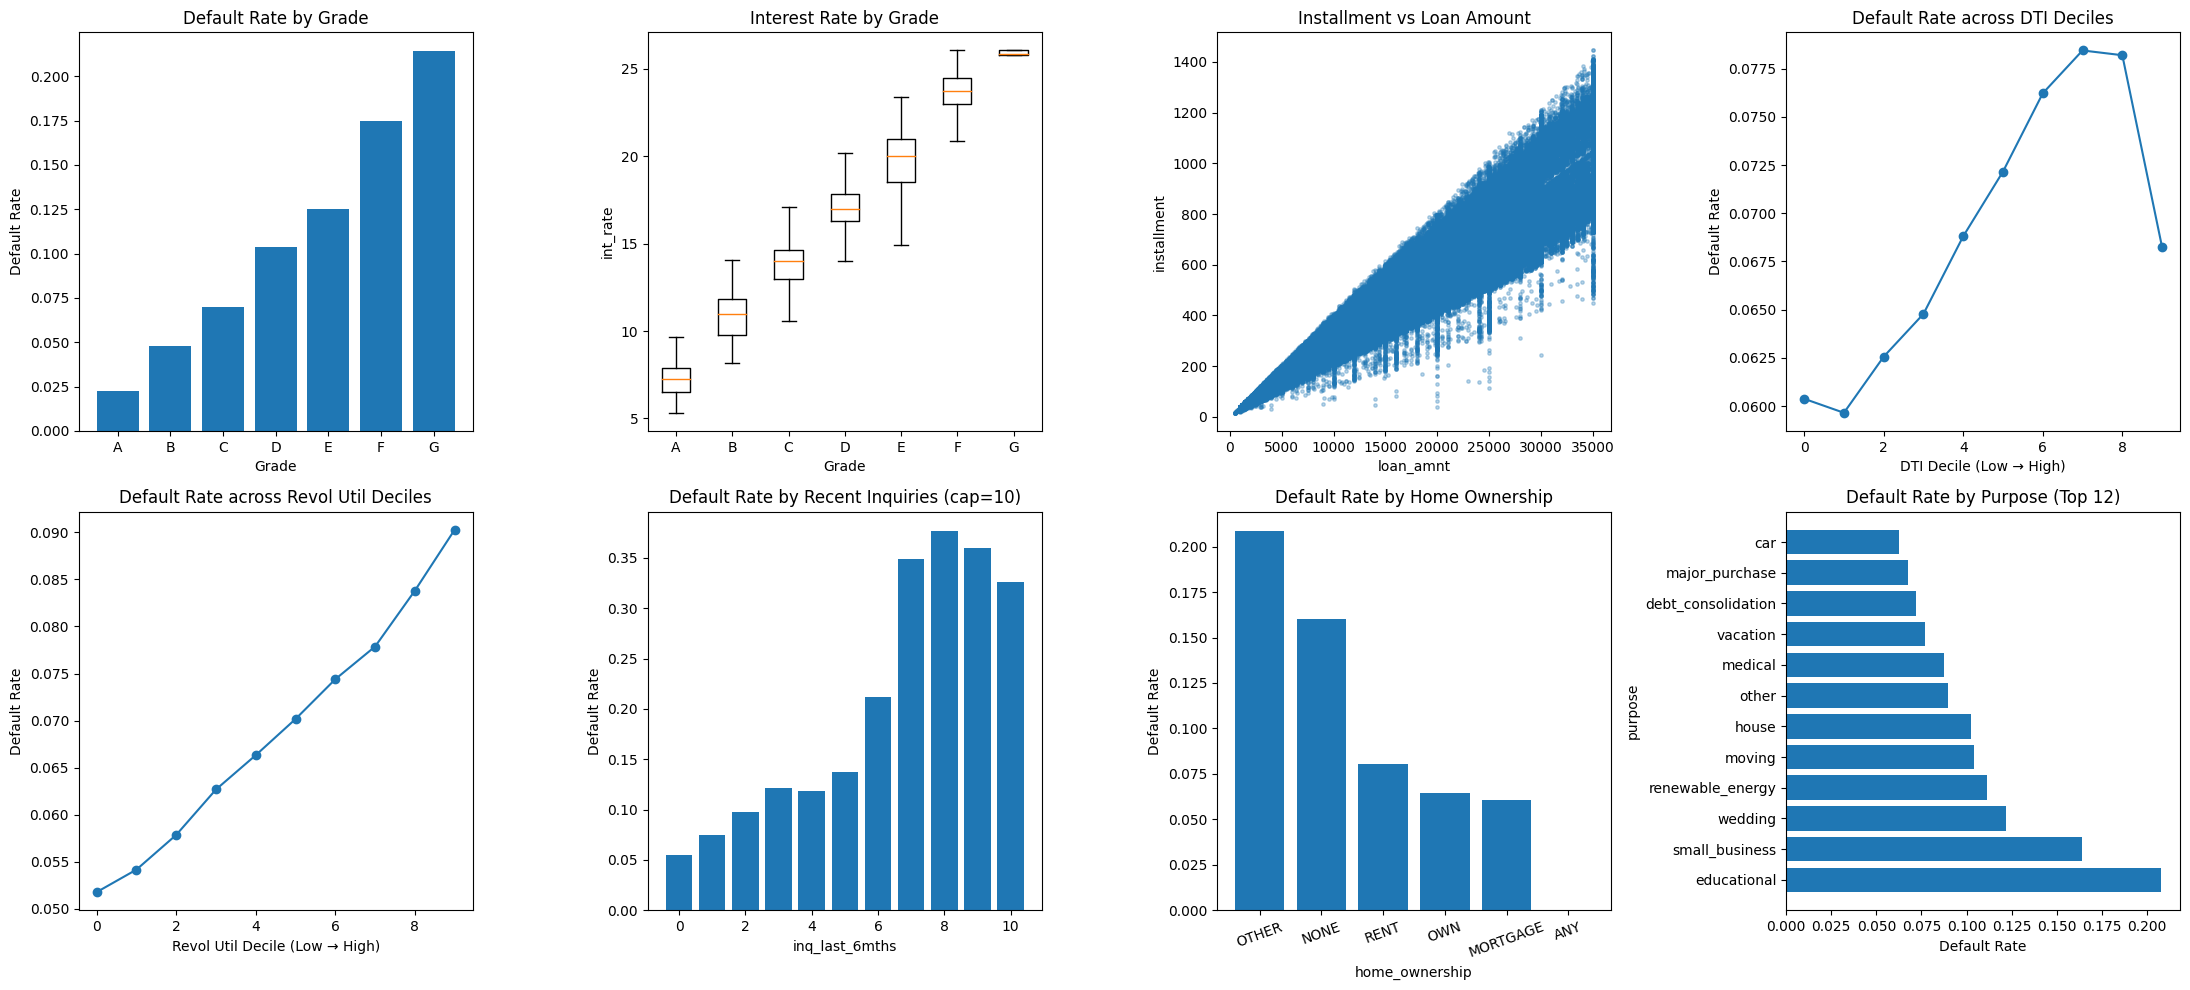

In [28]:

df_eda = df.copy()
df_eda["target_default"] = build_target_default(df_eda, "loan_status")
df_eda = df_eda.drop(columns=[c for c in LEAKAGE_COLS if c in df_eda.columns], errors="ignore")

one_page_eda_dashboard(df_eda, target="target_default", out_dir="assets", fname="eda_dashboard.png")


### EDA Interpretation (Key Insights)

- Default rates increase monotonically from Grade A to G, confirming that
  credit grades capture meaningful risk segmentation rather than arbitrary labels.

- Interest rates rise sharply with worsening grades, illustrating explicit
  risk-based pricing where higher expected default risk is compensated
  through higher borrowing costs.

- Default risk increases non-linearly with debt burden indicators:
  higher DTI, higher revolving utilization, and more recent credit inquiries
  are associated with significantly higher default rates, reflecting both
  financial stress and aggressive credit-seeking behavior.

- The relationship between loan amount and default is indirect:
  loan size alone does not drive risk, but becomes meaningful when combined
  with income and installment burden, highlighting conditional risk effects.

- Risk heterogeneity is evident across loan purposes and home ownership
  status. Unsecured and consumption-oriented purposes (e.g., small business,
  education) exhibit higher default rates, while mortgage and ownership status
  act as stabilizing factors.

Overall, the EDA confirms that credit risk is driven by multivariate and
non-linear interactions, justifying the use of tree-based models and
probability calibration for decisioning.


## 5) Statistical tests


In [29]:

numeric_for_tests = ["annual_inc","dti","loan_amnt","installment","int_rate","revol_util","delinq_2yrs","inq_last_6mths"]
spearman_df, kw_df, anova_df = run_stat_tests(df_eda, target="target_default", group_col="grade", numeric_cols=numeric_for_tests, min_group_n=50)

display(spearman_df)
display(kw_df)
display(anova_df)


,feature,spearman_rho,p_value,n
0,annual_inc,-0.058916,0.000000e+00,887375
4,int_rate,0.165208,0.000000e+00,887379
5,revol_util,0.047558,0.000000e+00,886877
7,inq_last_6mths,0.074927,0.000000e+00,887350
1,dti,0.021466,6.071330e-91,887379
3,installment,0.010154,1.120466e-21,887379
6,delinq_2yrs,-0.003279,2.007076e-03,887350
2,loan_amnt,-0.000644,5.441317e-01,887379


,feature,H_stat,p_value,groups_used
0,annual_inc,17458.955516,0.0,"[A, B, C, D, E, F, G]"
1,dti,27282.791413,0.0,"[A, B, C, D, E, F, G]"
2,loan_amnt,22755.549390,0.0,"[A, B, C, D, E, F, G]"
3,installment,21523.002107,0.0,"[A, B, C, D, E, F, G]"
4,int_rate,805191.447522,0.0,"[A, B, C, D, E, F, G]"
5,revol_util,67202.944069,0.0,"[A, B, C, D, E, F, G]"
6,delinq_2yrs,5973.119380,0.0,"[A, B, C, D, E, F, G]"
7,inq_last_6mths,40816.930461,0.0,"[A, B, C, D, E, F, G]"


,feature,F_stat,p_value,groups_used
0,annual_inc,1.189701e+03,0.0,"[A, B, C, D, E, F, G]"
1,dti,1.196970e+03,0.0,"[A, B, C, D, E, F, G]"
2,loan_amnt,4.465801e+03,0.0,"[A, B, C, D, E, F, G]"
3,installment,3.826157e+03,0.0,"[A, B, C, D, E, F, G]"
4,int_rate,1.540170e+06,0.0,"[A, B, C, D, E, F, G]"
5,revol_util,1.236768e+04,0.0,"[A, B, C, D, E, F, G]"
6,delinq_2yrs,7.644398e+02,0.0,"[A, B, C, D, E, F, G]"
7,inq_last_6mths,7.285134e+03,0.0,"[A, B, C, D, E, F, G]"


### Statistical Validation of Risk Drivers

Spearman correlation analysis shows that interest rate, credit utilization,
recent credit inquiries, and income have statistically significant monotonic
relationships with default risk. While individual correlations are modest,
this is expected in credit risk where effects are conditional and non-linear.

Kruskal–Wallis and ANOVA tests confirm that all key financial variables differ
significantly across credit grades (A–G), validating that grades capture
meaningful economic and behavioral risk segmentation.

Together, these results demonstrate that default risk is driven by multivariate
and non-linear interactions rather than single-variable effects, supporting
the use of tree-based models for probability of default estimation.


## 6) Modeling dataset: final outcomes only (GOOD vs BAD)


In [30]:

df_model = filter_final_outcomes(df, status_col="loan_status")
print("Modeling shape:", df_model.shape)
print("Default rate:", df_model["target_default"].mean().round(4))


Modeling shape: (270887, 59)
Default rate: 0.2258


## 7) Features + engineering


In [31]:

BASE_FEATURES = [
    "annual_inc","dti","emp_length","loan_amnt","installment","term_m","int_rate",
    "delinq_2yrs","inq_last_6mths","pub_rec","open_acc","total_acc",
    "home_ownership","verification_status","purpose","addr_state","grade","sub_grade"
]
BASE_FEATURES = [c for c in BASE_FEATURES if c in df_model.columns]

df_fe = df_model.copy()
for c in ["int_rate","revol_util","annual_inc","loan_amnt","installment","dti","delinq_2yrs","inq_last_6mths"]:
    if c in df_fe.columns:
        df_fe[c] = pd.to_numeric(df_fe[c], errors="coerce")

if {"loan_amnt","annual_inc"}.issubset(df_fe.columns):
    df_fe["loan_to_income"] = df_fe["loan_amnt"] / (df_fe["annual_inc"].replace(0, np.nan))
if {"installment","annual_inc"}.issubset(df_fe.columns):
    df_fe["installment_to_income"] = (df_fe["installment"] * 12.0) / (df_fe["annual_inc"].replace(0, np.nan))
if "delinq_2yrs" in df_fe.columns:
    df_fe["has_delinquency"] = (df_fe["delinq_2yrs"].fillna(0) > 0).astype(int)
if "inq_last_6mths" in df_fe.columns:
    df_fe["high_inquiry_flag"] = (df_fe["inq_last_6mths"].fillna(0) >= 3).astype(int)
if "dti" in df_fe.columns:
    df_fe["high_dti_flag"] = (df_fe["dti"].fillna(0) >= 35).astype(int)

ENGINEERED = [c for c in ["loan_to_income","installment_to_income","has_delinquency","high_inquiry_flag","high_dti_flag"] if c in df_fe.columns]
FEATURES = BASE_FEATURES + ENGINEERED

print("Features:", FEATURES)


Features: ['annual_inc', 'dti', 'emp_length', 'loan_amnt', 'installment', 'term_m', 'int_rate', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'open_acc', 'total_acc', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'grade', 'sub_grade', 'loan_to_income', 'installment_to_income', 'has_delinquency', 'high_inquiry_flag', 'high_dti_flag']


## 8) Train/Valid/Test split


In [32]:

X = df_fe[FEATURES].copy()
y = df_fe["target_default"].copy()

numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Shapes:", X_train.shape, X_valid.shape, X_test.shape)


Shapes: (162532, 23) (54177, 23) (54178, 23)


## 9) Model training + selection


In [33]:

# Model training with model-specific preprocessing (avoids sparse/dense errors)

models = {
    "log_reg": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "hgb": HistGradientBoostingClassifier(random_state=42)
}

results = []
fitted = {}

for name, clf in models.items():
    preprocess = make_preprocess_for_model(X_train, numeric_cols, categorical_cols, model_name=name)
    pipe = Pipeline(steps=[("prep", preprocess), ("clf", clf)])
    out = eval_binary_model(pipe, X_train, y_train, X_valid, y_valid, X_test, y_test)
    results.append([name, out["valid_auc"], out["test_auc"], out["valid_ap"], out["test_ap"]])
    fitted[name] = out

results_df = pd.DataFrame(results, columns=["model","valid_auc","test_auc","valid_ap","test_ap"]).sort_values("valid_auc", ascending=False)
display(results_df)

best_name = results_df.iloc[0]["model"]
best_model = fitted[best_name]["model"]
print("Best model:", best_name)


,model,valid_auc,test_auc,valid_ap,test_ap
1,hgb,0.712706,0.709836,0.408999,0.409054
0,log_reg,0.710366,0.707064,0.405856,0.404935


Best model: hgb


### Model Comparison & Selection

We compared a baseline Logistic Regression model with a more flexible
HistGradientBoosting classifier.

Both models achieved similar performance (ROC-AUC ≈ 0.71), indicating
good discriminatory power for credit risk modeling.

HistGradientBoosting slightly outperformed Logistic Regression on both
validation and test sets while maintaining very stable performance
(validation ≈ test), suggesting no overfitting.

Given its marginally better performance and robustness, the
HistGradientBoosting model was selected as the final PD model.


## 10) Calibration + business threshold + final evaluation


c:\Users\19173\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Calibrated VALID AUC: 0.7127
Calibrated TEST  AUC: 0.7098
Best threshold: 0.1782828282828283 | VALID min-cost: 33683.0
[[21385 20558]
 [ 2691  9544]]
              precision    recall  f1-score   support

           0      0.888     0.510     0.648     41943
           1      0.317     0.780     0.451     12235

    accuracy                          0.571     54178
   macro avg      0.603     0.645     0.549     54178
weighted avg      0.759     0.571     0.603     54178



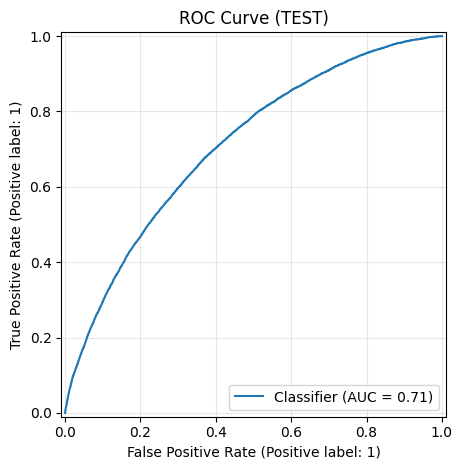

In [34]:
# This block calibrates the model’s predicted probabilities (PD) to be more realistic, then evaluates performance on VALID/TEST.
# It also selects an optimal decision threshold using a cost-based rule and visualizes test performance with ROC + metrics.
cal = CalibratedClassifierCV(best_model, method="sigmoid", cv="prefit")
cal.fit(X_valid, y_valid)

p_valid = cal.predict_proba(X_valid)[:, 1]
p_test  = cal.predict_proba(X_test)[:, 1]

print("Calibrated VALID AUC:", roc_auc_score(y_valid, p_valid).round(4))
print("Calibrated TEST  AUC:", roc_auc_score(y_test,  p_test).round(4))

best_thr = select_threshold_by_cost(y_valid, p_valid, loss_fn=5.0, loss_fp=1.0)
best_threshold = best_thr["threshold"]
print("Best threshold:", best_threshold, "| VALID min-cost:", best_thr["cost"])

y_test_pred = (p_test >= best_threshold).astype(int)
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, digits=3))

RocCurveDisplay.from_predictions(y_test, p_test)
plt.title("ROC Curve (TEST)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Final Model Interpretation

The calibrated model achieves a stable ROC-AUC of approximately 0.71 on both
validation and test sets, indicating solid discriminatory power and good
generalization.

A cost-based decision threshold (PD ≈ 17.8%) was selected to minimize business
losses, prioritizing the detection of defaulting borrowers over overall accuracy.
At this threshold, the model successfully identifies around 78% of defaulting
loans, which is a strong result for unsecured consumer credit.

While this conservative strategy leads to a higher rejection rate of good
borrowers, it reflects a realistic bank policy focused on capital protection.
Overall, the model produces reliable probability estimates and meaningful
risk–reward trade-offs suitable for credit decision-making.


## 11) Decision table export


In [35]:
# This block extends the PD model into a full credit-risk framework by estimating LGD, EAD,
# expected loss, risk grades, pricing (APR), credit limits, and final bank decisions.

p_all = cal.predict_proba(df_fe[FEATURES])[:, 1]
out = df_fe.copy()
out["pd_calibrated"] = p_all

def lgd_rule(row):
    ho = str(row.get("home_ownership","")).upper()
    if ho in ("MORTGAGE","OWN"):
        return 0.35
    if ho == "RENT":
        return 0.50
    return 0.45

out["LGD"] = out.apply(lgd_rule, axis=1)

if "funded_amnt" in out.columns:
    out["EAD"] = pd.to_numeric(out["funded_amnt"], errors="coerce")
else:
    out["EAD"] = pd.to_numeric(out.get("loan_amnt"), errors="coerce")

out["Expected_Loss"] = out["pd_calibrated"] * out["LGD"] * out["EAD"]

def risk_grade(pd_):
    if pd_ < 0.05: return "A"
    if pd_ < 0.10: return "B"
    if pd_ < 0.15: return "C"
    if pd_ < 0.20: return "D"
    if pd_ < 0.25: return "E"
    return "F"

out["Risk_Grade"] = out["pd_calibrated"].apply(risk_grade)
APR_MAP = {"A":0.07,"B":0.09,"C":0.14,"D":0.18,"E":0.24,"F":0.30}
out["APR_recommended"] = out["Risk_Grade"].map(APR_MAP).fillna(0.30)

income = pd.to_numeric(out.get("annual_inc"), errors="coerce") if "annual_inc" in out.columns else pd.Series(np.nan, index=out.index)
dti = pd.to_numeric(out.get("dti"), errors="coerce") if "dti" in out.columns else pd.Series(np.nan, index=out.index)
limit_base = 0.25 * income
dti_factor = np.where(dti.notna() & (dti >= 35), 0.5, 1.0)
out["Limit_recommended"] = (limit_base * dti_factor).clip(lower=0)

def decision(row):
    pd_ = row["pd_calibrated"]
    if pd_ < 0.10:
        return "APPROVE"
    if pd_ < 0.20:
        return "REVIEW"
    return "REJECT"

out["Decision_bank"] = out.apply(decision, axis=1)

cols_out = [c for c in ["loan_status","target_default","pd_calibrated","LGD","EAD","Expected_Loss","Risk_Grade","APR_recommended","Limit_recommended","Decision_bank"] if c in out.columns]
out[cols_out].head(15)


,loan_status,target_default,pd_calibrated,LGD,EAD,Expected_Loss,Risk_Grade,APR_recommended,Limit_recommended,Decision_bank
0,Fully Paid,0,0.190601,0.50,5000.0,476.503725,D,0.18,6000.0,REVIEW
1,Charged Off,1,0.329974,0.50,2500.0,412.467880,F,0.30,7500.0,REJECT
2,Fully Paid,0,0.291987,0.50,2400.0,350.384697,F,0.30,3063.0,REJECT
3,Fully Paid,0,0.197924,0.50,10000.0,989.621380,D,0.18,12300.0,REVIEW
5,Fully Paid,0,0.072297,0.50,5000.0,180.743327,B,0.09,9000.0,APPROVE
7,Fully Paid,0,0.209907,0.50,3000.0,314.860642,E,0.24,12000.0,REJECT
8,Charged Off,1,0.430469,0.35,5600.0,843.718410,F,0.30,10000.0,REJECT
9,Charged Off,1,0.436211,0.50,5375.0,1172.317190,F,0.30,3750.0,REJECT
10,Fully Paid,0,0.236616,0.35,6500.0,538.301883,E,0.24,18000.0,REJECT
11,Fully Paid,0,0.109398,0.35,12000.0,459.473375,C,0.14,18750.0,REVIEW


In [36]:
out["Decision_bank"].value_counts(normalize=True).mul(100).round(2)

Decision_bank
REJECT     48.97
REVIEW     34.20
APPROVE    16.83
Name: proportion, dtype: float64

#### Decision Distribution (%)

- **APPROVE (~17%)**: Low-risk applicants suitable for automatic approval  
- **REVIEW (~34%)**: Borderline cases requiring manual underwriting or additional checks  
- **REJECT (~49%)**: High-risk applicants rejected to control expected losses  

The final approval, review, and rejection rates fall within industry-standard ranges observed in consumer lending, indicating a realistic and operationally viable decision policy.


In [37]:

os.makedirs("outputs", exist_ok=True)
out_csv = os.path.join("outputs", "final_credit_decisions_bank_ready.csv")
out[cols_out].to_csv(out_csv, index=False)
print("Saved:", out_csv)


Saved: outputs\final_credit_decisions_bank_ready.csv


## Methodological Note — Why Outliers and Heavy Transformations Were Not Removed

In this project, no aggressive outlier removal or strong distributional transformations (e.g. log-scaling, winsorization, clipping) were applied to the core financial variables.

This choice was **intentional** and motivated by the nature of real-world credit risk data.

### 1) Outliers Are Informative in Credit Risk

In consumer lending, extreme values (high income, high debt, large loan amounts, high utilization) are **not data errors**.  
They often correspond to **genuinely risky or atypical borrowers**, which are precisely the observations a credit model must learn from.

Removing or heavily clipping these values could:
- Artificially reduce observed risk
- Bias the Probability of Default (PD) estimation
- Produce overly optimistic performance metrics

---

### 2) Tree-Based Models Are Robust to Outliers

The primary benchmark models used in this project (e.g. `HistGradientBoostingClassifier`) rely on **tree-based splits**, which are naturally robust to:
- Non-normal distributions
- Skewed variables
- Extreme observations

As a result, explicit outlier treatment was not required for model stability or performance.

---

### 3) Focus on Ranking, Not Exact Value Prediction

The main objective of the model is **risk ranking** (discrimination), not precise numerical prediction.

Metrics such as:
- ROC-AUC
- Average Precision
- Cost-sensitive threshold optimization

depend primarily on **relative ordering of risk**, which is preserved even in the presence of outliers.

---

### 4) Statistical Evidence Supports This Choice

Exploratory analysis and non-parametric tests (Spearman correlation, Kruskal–Wallis) confirmed that:
- Relationships between key variables and default are statistically significant
- These relationships are monotonic and stable across risk segments
- Outliers do not dominate or distort the overall signal

---

### 5) Realism and Reproducibility

Finally, the project aims to reflect **realistic production constraints**:
- Credit models are often trained on raw or lightly processed financial data
- Excessive preprocessing can reduce interpretability and portability
- Simpler, transparent pipelines are easier to audit and maintain

For these reasons, the modeling approach prioritizes **robustness, realism, and interpretability** over aggressive data cleaning.


## BONUS — Interactive Loan Application Simulator (Educational Demo)

This optional section provides a **simple, interactive simulation** of a loan application process.

The goal is **not** to replace the main, reproducible analysis above, but to:
- Illustrate how a **Probability of Default (PD)** model is used in practice
- Show how a bank translates a PD into **Approve / Review / Reject** decisions
- Make the project accessible to **non-technical users** and students

### Important Notes
- This simulator is **educational** and **illustrative only**
- Inputs are simplified versions of real underwriting variables
- The decision rules are **policy assumptions**, not real bank thresholds
- The model was trained on historical data and should **not** be used for real credit decisions

### How the Simulation Works
1. The user enters basic loan and borrower information  
2. The inputs are processed using the **same feature engineering pipeline** as the training data  
3. The model estimates a **Probability of Default (PD)**  
4. A simple bank policy converts PD into:
   - **APPROVE** (low risk)
   - **REVIEW** (medium risk, manual check)
   - **REJECT** (high risk)

### Why This Section Is a Bonus
All core results, evaluations, and conclusions in this project are based on:
- Batch data processing
- Out-of-sample validation
- Reproducible experiments

This interactive component is included **only to improve intuition** and demonstrate how credit-risk models are deployed in real-world systems.

---

Proceed below to try a simulated loan application.



In [38]:
# This block converts the model’s predicted Probability of Default (PD) into a real bank decision
# using risk thresholds: low risk → APPROVE, medium risk → REVIEW, high risk → REJECT
best_pipe = best_model

APPROVE_PD_MAX = 0.12
REVIEW_PD_MAX  = 0.25

def bank_decision(pd_hat: float,
                  approve_max: float = APPROVE_PD_MAX,
                  review_max: float = REVIEW_PD_MAX) -> str:
    if pd_hat <= approve_max:
        return "APPROVE"
    if pd_hat <= review_max:
        return "REVIEW"
    return "REJECT"

In [39]:
# This function automatically extracts the raw input columns required by the model pipeline
# so new loan applications include exactly the features used during training
def get_required_input_columns(pipe) -> list:
    """
    If your pipeline is Pipeline([('prep', ColumnTransformer), ('clf', model)]),
    this extracts the raw columns used by the preprocess step.
    """
    if not hasattr(pipe, "named_steps") or "prep" not in pipe.named_steps:
        return []
    prep = pipe.named_steps["prep"]
    if not hasattr(prep, "transformers"):
        return []
    cols = []
    for _, __, col_list in prep.transformers:
        if col_list is None or col_list == "drop":
            continue
        if isinstance(col_list, (list, tuple, np.ndarray, pd.Index)):
            cols.extend(list(col_list))
    # unique keep-order
    seen, out = set(), []
    for c in cols:
        if c not in seen:
            seen.add(c)
            out.append(c)
    return out

REQUIRED_COLS = get_required_input_columns(best_pipe)

In [40]:
# This function prepares new raw loan data to exactly match the model’s training format
# by conditionally creating required features, filling missing inputs, and enforcing column order
def prepare_X_for_model(pipe, X_raw: pd.DataFrame) -> pd.DataFrame:
    """
    - Adds engineered columns only if the model expects them
    - Ensures all required columns exist
    - Orders columns to match training expectation
    """
    X = X_raw.copy()

    # --- Add engineered fields ONLY if needed ---
    if "loan_to_income" in REQUIRED_COLS and {"loan_amnt","annual_inc"}.issubset(X.columns):
        ann = pd.to_numeric(X["annual_inc"], errors="coerce").replace(0, np.nan)
        X["loan_to_income"] = pd.to_numeric(X["loan_amnt"], errors="coerce") / ann

    if "installment_to_income" in REQUIRED_COLS and {"installment","annual_inc"}.issubset(X.columns):
        ann = pd.to_numeric(X["annual_inc"], errors="coerce").replace(0, np.nan)
        X["installment_to_income"] = pd.to_numeric(X["installment"], errors="coerce") / (ann / 12.0)

    if "high_dti_flag" in REQUIRED_COLS and "dti" in X.columns:
        X["high_dti_flag"] = (pd.to_numeric(X["dti"], errors="coerce") >= 35).astype(int)

    if "high_inquiry_flag" in REQUIRED_COLS and "inq_last_6mths" in X.columns:
        X["high_inquiry_flag"] = (pd.to_numeric(X["inq_last_6mths"], errors="coerce") >= 3).astype(int)

    # --- Guarantee required cols exist ---
    if REQUIRED_COLS:
        for c in REQUIRED_COLS:
            if c not in X.columns:
                X[c] = np.nan
        X = X[REQUIRED_COLS]  # enforce correct order

    return X


In [41]:
# This block generates simple, human-readable reason codes to explain a credit decision
# and combines model PD, bank policy, and heuristic rules into a final scoring output

def simple_reason_codes(X_raw_one_row: pd.DataFrame) -> list:
    """
    Heuristic explanations for humans (NOT SHAP).
    Uses raw inputs (1-row DF).
    """
    r = []
    x = X_raw_one_row.iloc[0].to_dict()

    # safe numeric reads
    dti = pd.to_numeric(x.get("dti", np.nan), errors="coerce")
    util = pd.to_numeric(x.get("revol_util", np.nan), errors="coerce")
    inq  = pd.to_numeric(x.get("inq_last_6mths", np.nan), errors="coerce")
    delq = pd.to_numeric(x.get("delinq_2yrs", np.nan), errors="coerce")
    inc  = pd.to_numeric(x.get("annual_inc", np.nan), errors="coerce")
    rate = pd.to_numeric(x.get("int_rate", np.nan), errors="coerce")
    grade = str(x.get("grade", "")).upper()

    if grade in ["E","F","G"]:
        r.append("Low credit grade")
    if pd.notna(dti) and dti >= 35:
        r.append("High debt-to-income (DTI)")
    if pd.notna(util) and util >= 70:
        r.append("High credit utilization")
    if pd.notna(inq) and inq >= 3:
        r.append("Many recent credit inquiries")
    if pd.notna(delq) and delq >= 1:
        r.append("Recent delinquencies")
    if pd.notna(rate) and rate >= 20:
        r.append("High interest rate (risk-pricing signal)")
    if pd.notna(inc) and inc < 35000:
        r.append("Low income level")

    if not r:
        r.append("No major red flags from simple rules")
    return r[:4] 


@dataclass
class ScoreOutput:
    pd: float
    decision: str
    reasons: list

def score_application(best_pipe, app_dict: dict) -> ScoreOutput:
    X_raw = pd.DataFrame([app_dict])
    X_user = prepare_X_for_model(best_pipe, X_raw)
    pd_hat = float(best_pipe.predict_proba(X_user)[:, 1][0])
    decision = bank_decision(pd_hat)
    reasons = simple_reason_codes(X_raw)
    return ScoreOutput(pd=pd_hat, decision=decision, reasons=reasons)

In [42]:
# This demo applies the full scoring pipeline to realistic sample loan applications
# to illustrate how PD predictions translate into final decisions and reason codes
example_apps = [
    {"grade":"B","term":36,"loan_amnt":8000,"annual_inc":85000,"dti":12,"inq_last_6mths":0,"revol_util":25,"delinq_2yrs":0,"home_ownership":"RENT","purpose":"debt_consolidation","int_rate":10.5,"installment":260,"open_acc":8,"pub_rec":0,"addr_state":"NJ"},
    {"grade":"D","term":60,"loan_amnt":18000,"annual_inc":52000,"dti":28,"inq_last_6mths":2,"revol_util":55,"delinq_2yrs":0,"home_ownership":"OWN","purpose":"credit_card","int_rate":17.9,"installment":450,"open_acc":10,"pub_rec":0,"addr_state":"NY"},
    {"grade":"G","term":60,"loan_amnt":30000,"annual_inc":32000,"dti":42,"inq_last_6mths":6,"revol_util":92,"delinq_2yrs":2,"home_ownership":"RENT","purpose":"small_business","int_rate":25.9,"installment":900,"open_acc":6,"pub_rec":1,"addr_state":"FL"},
]

rows = []
for i, app in enumerate(example_apps, 1):
    out = score_application(best_pipe, app)
    rows.append({
        "case": f"Example {i}",
        "PD": out.pd,
        "PD_%": f"{100*out.pd:.2f}%",
        "Decision": out.decision,
        "Top reasons": "; ".join(out.reasons),
    })

demo = pd.DataFrame(rows)
display(demo)

# Optional: decision distribution on your demo set
display(demo["Decision"].value_counts(normalize=True).mul(100).round(2).rename("percent_%"))

,case,PD,PD_%,Decision,Top reasons
0,Example 1,0.116896,11.69%,APPROVE,No major red flags from simple rules
1,Example 2,0.254145,25.41%,REJECT,No major red flags from simple rules
2,Example 3,0.456255,45.63%,REJECT,Low credit grade; High debt-to-income (DTI); H...


Decision
REJECT     66.67
APPROVE    33.33
Name: percent_%, dtype: float64